In [1]:
import numpy as np
import seaborn as sns
from IPython.core.display import HTML
import matplotlib.pyplot as plt

sns.set()

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [7]:
"""
Thermal model of the robot. Parameters adopted from:
Fei, Teng, et al. "A body temperature model for lizards as estimated from the thermal environment." Journal of Thermal Biology 37.1 (2012): 56-64.

Torque-Heat model is inspired by the thermo dynamic model of the electric motor
Venkataraman, B., et al. "Fundamentals of a motor thermal model and its applications in motor protection." 58th Annual Conference for Protective Relay Engineers, 2005.. IEEE, 2005.

Absolute temperature is used only inside of the module and all methods use Celsius degree.
"""

import numpy as np
import enum
from enum import Enum


class Climate(Enum):
    default = 300  # [Wm^-2]  (300 in original paper)
    sunny = 600  # [Wm^-2] Assuming many cloud though. Full sunny day means ~1000 but agent cannot control in our environment! TODO: Add shade in the environment
    cloudy = 300  # [Wm^-2]


class ThermalModule():
    M = 0.19  # [kg] lizard data. (ant torso mass is np.pi * (3/4) * 0.25 ** 3 * 5 = 0.184 [kg])
    alpha_L = 0.936  # [-]
    C_l = 3762  # [JK^-1kg^-1]
    delta = 0.015  # [m]
    K_l = 0.502  # [WK^-1m^-1]
    h_L = 10.45  # [Wm^-2K^-1]
    a = 0.0314  # shape coeff
    A_L = a * np.pi * M ** (2./3)  # [m^2]
    A_p = 0.4 * A_L  # [m^2]
    A_down = 0.3 * A_L  # [m^2]
    A_up = 0.6 * A_L  # [m^2]
    A_air = 0.9 * A_L  # [m^2]
    A_contact = 0.1 * A_L  # [m^2]
    eps_skin = 0.95  # [-]
    eps_land = 0.95  # [-]
    sigma = 5.67e-8  # Stefan-Boltzmann constant [Wm^-2K^-4]

    motor_coef = 5.  # Motor-heat coefficient

    initial_T = 311.  # default. 38 C

    def __init__(self, temp_init=38.):
        """

        :param temp_init: Initial body temperature in Celsius degree
        """
        self.T = np.array(temp_init + 273.)
        self.initial_T = np.array(temp_init + 273.)

    def reset(self, temp_init=None):
        """

        :param temp_init: Initial body temperature in Celsius degree
        :return:
        """
        if temp_init:
            self.initial_T = np.array(temp_init + 273.)

        self.T = np.array(self.initial_T)

    def _dQ_solar(self, climate: Climate):
        Q_solar_now = climate.value
        return self.alpha_L * self.A_p * Q_solar_now

    def _dQ_conv(self, T_now, temp_air):
        return self.h_L * self.A_air * (temp_air - T_now)

    def _dQ_longwave(self, T_now, temp_air, temp_earth):
        q_earth = self.eps_land * self.A_down * self.sigma * (temp_earth ** 4 - T_now ** 4)
        q_air = self.eps_skin * self.A_up * self.sigma * (temp_air ** 4 - T_now ** 4)
        return q_earth + q_air

    def _dQ_cond(self, T_now, temp_earth):
        return self.A_contact * self.K_l * (temp_earth - T_now) / (self.delta / 2.)

    def _delta_Q(self, T_now, action, evaporative_action, temp_air, temp_earth, climate):
        """
        Assuming all actions sould be scaled into [-1, +1]
        """

        dq1 = self._dQ_solar(climate) # solar ratiation
        dq2 = self._dQ_conv(T_now, temp_air)  # convection heat
        dq3 = self._dQ_longwave(T_now, temp_air, temp_earth)  # long-wave heat
        dq4 = self._dQ_cond(T_now, temp_earth)  # conductive heat
        dq5 = self.motor_coef * sum(np.square(action))  # motor heat production

        max_ev = 0.3
        min_ev = 0.272 * self.M
        dq6 = 0.5 * (max_ev - min_ev) * (evaporative_action + 1) + min_ev

        dQ = dq1 + dq2 + dq3 + dq4 + dq5 - dq6
        return dQ

    def _grad_T(self, T_now, action, evaporative_action, temp_air, temp_earth, climate):
        return self._delta_Q(T_now, action, evaporative_action, temp_air, temp_earth, climate) / (self.C_l * self.M)

    def step(self, motor_action, evaporative_action, temp_air_c, temp_earth_c, dt, climate=Climate.cloudy, mode="RK4"):
        """
        One-step progress of the thermal model. return the latest body temperature in Celsius degree
        :param motor_action:
        :param evaporative_action:
        :param temp_air_c: air/sky temperature in Celsius degree
        :param temp_earth_c: earth/soil temperature in Celsius degree
        :param dt: time tick of the thermal model
        :param climate: Climate to choose solar radiation
        :return:
        """
        
        # Eular
        if mode == "Eular":
            T_now = self.T
            dT = self._grad_T(T_now, motor_action, evaporative_action, temp_air_c + 273., temp_earth_c + 273., climate)
            dT *= dt
        elif mode == "RK4":
            # RK4 based on https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#The_Runge%E2%80%93Kutta_method
            T_now = self.T
            k1 = self._grad_T(T_now, motor_action, evaporative_action, temp_air_c + 273., temp_earth_c + 273., climate)
            k2 = self._grad_T(T_now + dt * k1 / 2., motor_action, evaporative_action, temp_air_c + 273., temp_earth_c + 273., climate)
            k3 = self._grad_T(T_now + dt * k2 / 2., motor_action, evaporative_action, temp_air_c + 273., temp_earth_c + 273., climate)
            k4 = self._grad_T(T_now + dt * k3, motor_action, evaporative_action, temp_air_c + 273., temp_earth_c + 273., climate)
            #print(k1, k2, k3, k4)
            dT = (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6.
            #print("ave_k; ", (k1 + 2 * k2 + 2 * k3 + k4)/6.)
        else:
            raise ValueError("mode error")
            
        self.T += dT

        return self.T - 273.0

    def get_temp_now(self):
        return self.T.copy() - 273.0


18000


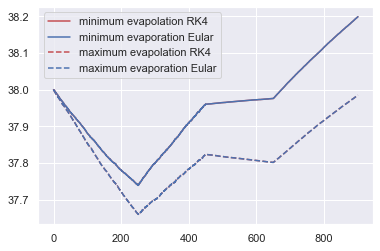

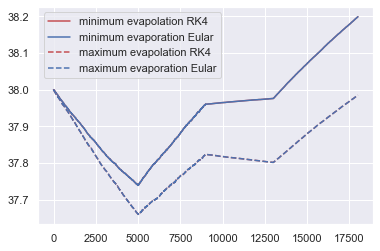

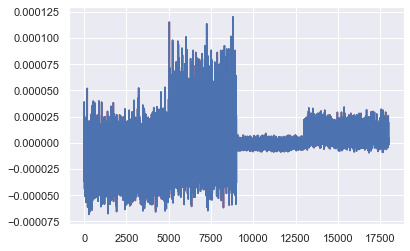

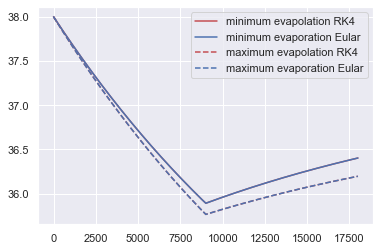

In [20]:
# Testing function

T_earth = 30    # [c]
T_air = 25       # [c]
T0_skin = 38.     # [c]

dt = 0.05
max_time = 900
max_time_step = int(max_time / dt)
print(max_time_step)

def get_trajectory(ev_action, is_zero_action=False):
    thermal_module_rk4 = ThermalModule()
    thermal_module_eular = ThermalModule()
    
    thermal_module_rk4.reset()
    thermal_module_eular.reset()
    
    T_hist_rk4 = []
    T_hist_e = []

    T_rk4 = np.array(T0_skin)
    T_e = np.array(T0_skin)
    for i in range(max_time_step):

        T_hist_rk4.append(T_rk4.copy())
        T_hist_e.append(T_e.copy())

        # non Shade and in active
        # down
        climate = Climate.cloudy
        action = 0.5 * np.random.uniform(-1, 1, 8) * (not is_zero_action)
        #action = 0.3 * np.ones(8)
        
        if i > 5000: # Shade and in active
            # up
            climate = Climate.cloudy
            action = 0.6 * np.random.uniform(-1, 1, 8) * (not is_zero_action)
            #action = 0.3 * np.ones(8)
            
        if i > 9000: # Shade and in active
            # down
            climate = Climate.sunny
            action = 0.2 * np.random.uniform(-1, 1, 8) * (not is_zero_action)
        
        if i > 13000: # Shade and in active
            # up
            climate = Climate.sunny
            action = 0.3 * np.random.uniform(-1, 1, 8) * (not is_zero_action)

        #  step(self, motor_action, evaporative_action, temp_air_c, temp_earth_c, dt, climate)
        T_rk4 = thermal_module_rk4.step(action, ev_action, T_air, T_earth, dt, climate, "RK4")
        T_e = thermal_module_eular.step(action, ev_action, T_air, T_earth, dt, climate, "Eular")

    return T_hist_rk4, T_hist_e

hist1_rk4, hist1_e = get_trajectory(-1)
plt.plot(np.linspace(0, max_time, max_time_step), hist1_rk4, "r")
plt.plot(np.linspace(0, max_time, max_time_step), hist1_e, "b")

hist2_rk4, hist2_e = get_trajectory(+1)
plt.plot(np.linspace(0, max_time, max_time_step), hist2_rk4, "--r")
plt.plot(np.linspace(0, max_time, max_time_step), hist2_e, "--b")

plt.legend(["minimum evapolation RK4",
            "minimum evaporation Eular",
            "maximum evapolation RK4",
            "maximum evaporation Eular"])
plt.show()

plt.plot(range(max_time_step), hist1_rk4, "r")
plt.plot(range(max_time_step), hist1_e, "b")
plt.plot(range(max_time_step), hist2_rk4, "--r")
plt.plot(range(max_time_step), hist2_e, "--b")

plt.legend(["minimum evapolation RK4",
            "minimum evaporation Eular",
            "maximum evapolation RK4",
            "maximum evaporation Eular"])
plt.show()

hist_rk4, hist_e = get_trajectory(+1)

def temp_scale(temp):
    return (temp - 38.)/(42 - 38)

diff_hist_rk4 = temp_scale(np.array(hist_rk4[1:])) - temp_scale(np.array(hist_rk4[:len(hist_rk4)-1]))
plt.plot(range(max_time_step - 1), diff_hist_rk4, "r")

diff_hist_e = temp_scale(np.array(hist_e[1:])) - temp_scale(np.array(hist_e[:len(hist_e)-1]))
plt.plot(range(max_time_step - 1), diff_hist_e, "b")

plt.show()

hist1_rk4, hist1_e = get_trajectory(-1, True)
plt.plot(range(max_time_step), hist1_rk4, "r")
plt.plot(range(max_time_step), hist1_e, "b")

hist2_rk4, hist2_e = get_trajectory(+1, True)
plt.plot(range(max_time_step), hist2_rk4, "--r")
plt.plot(range(max_time_step), hist2_e, "--b")

plt.legend(["minimum evapolation RK4",
            "minimum evaporation Eular",
            "maximum evapolation RK4",
            "maximum evaporation Eular"])
plt.show()

# Distribution of the lizard body temperature
from: 

DeWitt, Calvin B. “Precision of Thermoregulation and Its Relation to Environmental Factors in the Desert Iguana, Dipsosaurus Dorsalis.” <i>Physiological Zoology</i>, vol. 40, no. 1, 1967, pp. 49–66. <i>JSTOR</i>, www.jstor.org/stable/30152438. Accessed 10 Aug. 2021.

<div>
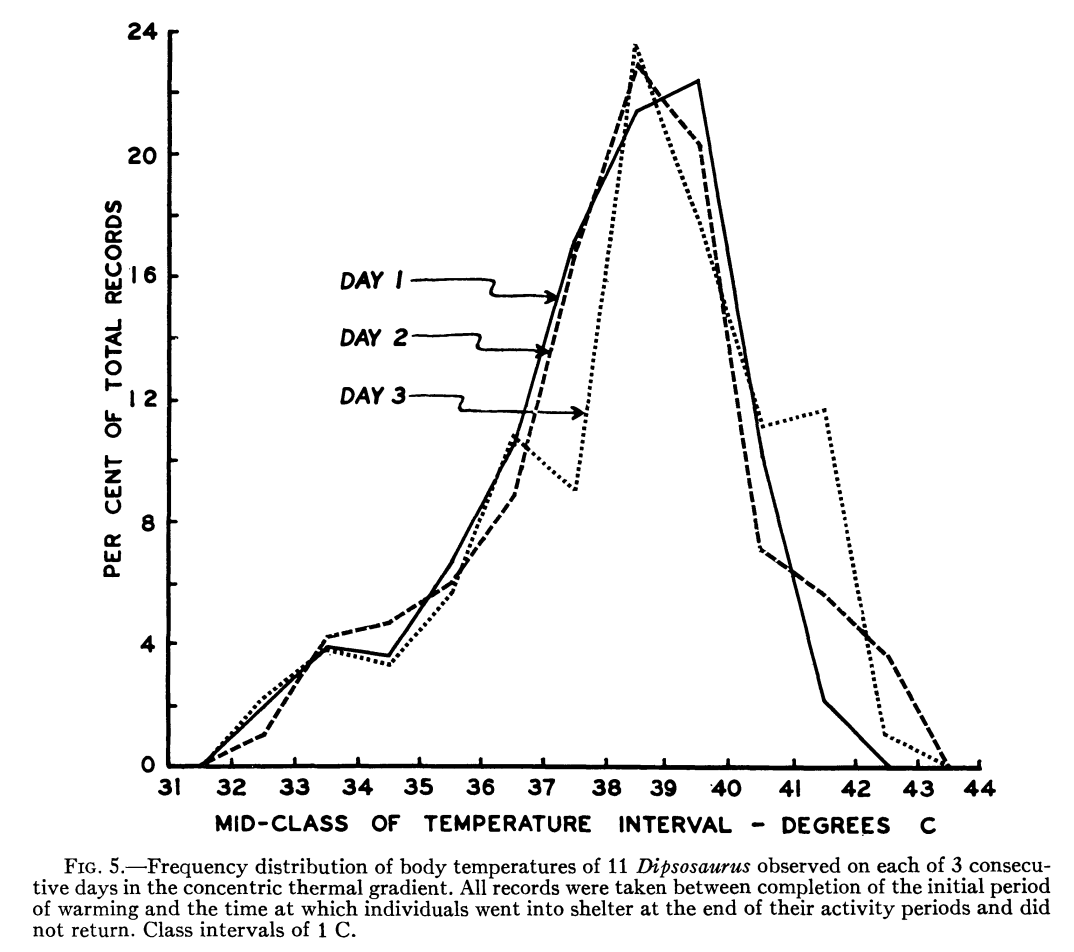
</div>

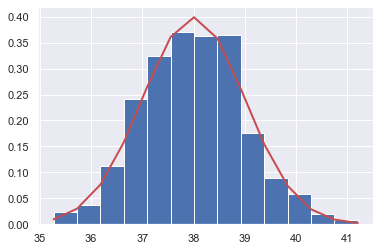

In [4]:
mu, sigma = 38, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

count, bins, ignored = plt.hist(s, 13, density=True)
plt.plot(bins,  1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [5]:
np.sum([1, 2, 3])

6